In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1



# Datasets loading and visualization

In [35]:
# Forming datasets

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.3)
# Training and validation dataset
train = datagen.flow_from_directory('./train', seed=123, subset='training')
val = datagen.flow_from_directory('./train', seed=123, subset='validation')

# Test dataset for evaluation
datagen2 = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test = datagen2.flow_from_directory('./val',
                                    target_size= (224,224),
                                    batch_size=32, 
                                    class_mode= 'categorical')

Found 7000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


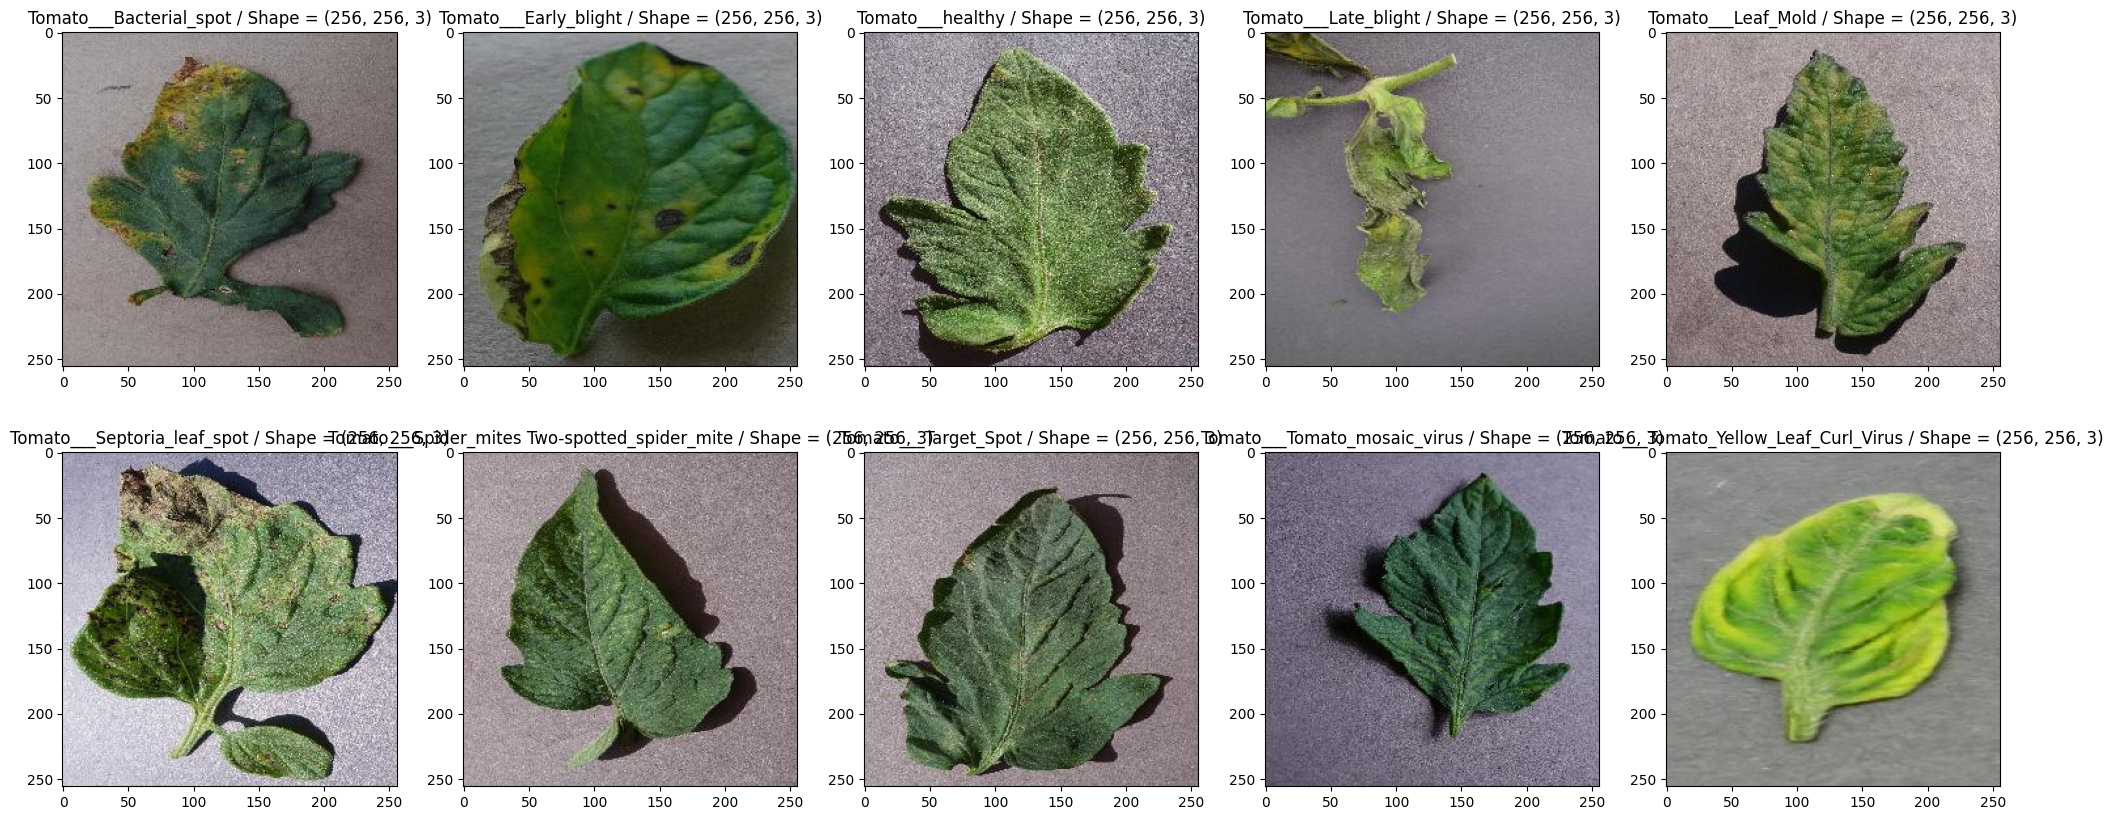

In [4]:
# Training data visualization

classes = os.listdir('./train')

plt.figure(figsize=(25,10))

for i in enumerate(classes):
    pic = os.listdir('./train/'+i[1])[7]
    image = Image.open('./train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2,5,i[0]+1)
    plt.title('{0} / Shape = {1}'.format(i[1], image.shape))
    plt.imshow(image)
plt.show()

# Creating the functions for VGG16_model() and ResNet152V2_model()


In [5]:
# Function to initialize model (ResNet152V2)

def ResNet152V2_model():
    
    base_model = ResNet152V2(input_shape=(256,256,3), include_top=False)
    
    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True
        
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    
    return model

In [6]:
# Function to initialize model (VGG16)
def VGG16_model():
    # Load VGG16 model with pre-trained weights and without the top classification layer
    base_model = VGG16(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
    
    # Freeze the initial layers for transfer learning
    for layer in base_model.layers[:15]:
        layer.trainable = False
    for layer in base_model.layers[15:]:
        layer.trainable = True
    
    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling
    x = Dense(1000, activation='relu')(x)  # Fully connected layer with ReLU activation
    pred = Dense(10, activation='softmax')(x)  # Output layer with 10 classes and softmax activation
    
    # Define the complete model
    model = Model(inputs=base_model.input, outputs=pred)
    
    return model


In [7]:
# Set up model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_vgg16_model.h5', monitor='val_loss', 
                             save_best_only=True, mode='min', verbose=1)

In [8]:
# Set up model checkpoint to save the best model
ResNet152V2_Checkpoint = ModelCheckpoint('best_resnet152v2_model.h5', monitor='val_loss', 
                             save_best_only=True, mode='min', verbose=1)

In [9]:
# Model initialization VGG16 
VGG16_model = VGG16_model()
VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [10]:
ResNet152V2_Model = ResNet152V2_model()
ResNet152V2_Model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# Training the two models

### First model VGG16_model 

In [12]:
# Model training
VGG16_model.compile(
    loss='categorical_crossentropy',
      optimizer='sgd', 
      metrics='accuracy',
          
      )

historyVGG = VGG16_model.fit(train, 
                batch_size=80, 
                epochs=32, 
                validation_data=val,
                callbacks=[checkpoint] )

Epoch 1/32
219/219 [==============================] - ETA: 0s - loss: 1.7319 - accuracy: 0.4061
Epoch 1: val_loss improved from inf to 1.12798, saving model to best_vgg16_model.h5
219/219 [==============================] - 48s 217ms/step - loss: 1.7319 - accuracy: 0.4061 - val_loss: 1.1280 - val_accuracy: 0.6240
Epoch 2/32
219/219 [==============================] - ETA: 0s - loss: 0.9254 - accuracy: 0.6871
Epoch 2: val_loss did not improve from 1.12798
219/219 [==============================] - 47s 213ms/step - loss: 0.9254 - accuracy: 0.6871 - val_loss: 1.6995 - val_accuracy: 0.4260
Epoch 3/32
219/219 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.7890
Epoch 3: val_loss improved from 1.12798 to 0.48102, saving model to best_vgg16_model.h5
219/219 [==============================] - 48s 217ms/step - loss: 0.6307 - accuracy: 0.7890 - val_loss: 0.4810 - val_accuracy: 0.8393
Epoch 4/32
219/219 [==============================] - ETA: 0s - loss: 0.4750 - accuracy: 0.

### Second model ResNet152V2_Model

In [13]:
# Model training
ResNet152V2_Model.compile(loss='categorical_crossentropy', 
                          optimizer='sgd',
                            metrics='accuracy')
ResNet152V2History = ResNet152V2_Model.fit(train, 
                batch_size=80, 
                epochs=24, 
                validation_data=val,
                callbacks=[ResNet152V2_Checkpoint] )

Epoch 1/24
219/219 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.8047
Epoch 1: val_loss improved from inf to 0.19176, saving model to best_resnet152v2_model.h5
219/219 [==============================] - 183s 774ms/step - loss: 0.6583 - accuracy: 0.8047 - val_loss: 0.1918 - val_accuracy: 0.9307
Epoch 2/24
219/219 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9806
Epoch 2: val_loss improved from 0.19176 to 0.11116, saving model to best_resnet152v2_model.h5
219/219 [==============================] - 166s 759ms/step - loss: 0.0733 - accuracy: 0.9806 - val_loss: 0.1112 - val_accuracy: 0.9637
Epoch 3/24
219/219 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9930
Epoch 3: val_loss improved from 0.11116 to 0.10464, saving model to best_resnet152v2_model.h5
219/219 [==============================] - 166s 758ms/step - loss: 0.0297 - accuracy: 0.9930 - val_loss: 0.1046 - val_accuracy: 0.9677
Epoch 4/24
219/219 [=========

## Model Evaluation 



##### 1. Evaluating VGG16_model 

In [17]:
# Load the best model if necessary
# Initialize the model
VGG16_model.load_weights('best_vgg16_model.h5')

# Evaluate on validation data
val_loss, val_accuracy = VGG16_model.evaluate(val)

94/94 [==============================] - 12s 121ms/step - loss: 0.1209 - accuracy: 0.9647


In [18]:
# Print evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Loss: 0.1208934634923935
Validation Accuracy: 0.9646666646003723


In [36]:
test_steps_per_epoch = np.math.ceil(test.samples/test.batch_size)

C:\Users\JANAH\AppData\Local\Temp\ipykernel_16928\328627303.py:1: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test.samples/test.batch_size)


In [47]:
predictions = VGG16_model.predict(test,steps=test_steps_per_epoch)
predicted_values = np.argmax(predictions, axis=1)
true_classes = test.classes
class_labels =list(test.class_indices)
class_labels 

32/32 [==============================] - 5s 167ms/step


['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test.classes  ,predicted_values)
print(cm)



[[ 7  4 16  7 12  7  9 11 14 13]
 [ 7 13 16 12 11 14  4  7  9  7]
 [16  7 12  8  8 12  7 11 10  9]
 [15  7  5  8 12 14  7 10  9 13]
 [12 10  7  5 15 12  6 15 10  8]
 [10 10  9 14 16  9 10  6 10  6]
 [12  6 10 11 12 11 10  7 13  8]
 [ 6 11  6 13 12 12  7 15 10  8]
 [11 15  9  8 13  9  7  7  9 12]
 [10  9 15 11 10  5 11  4 14 11]]


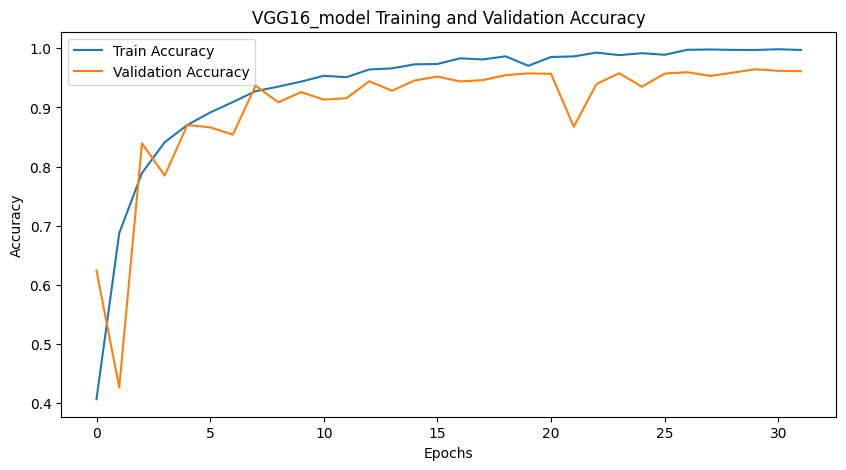

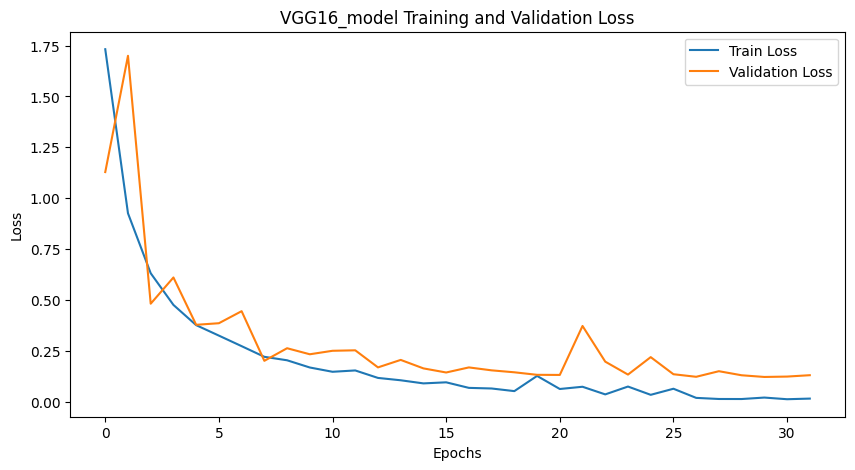

In [19]:

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(historyVGG.history['accuracy'], label='Train Accuracy')
plt.plot(historyVGG.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16_model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(historyVGG.history['loss'], label='Train Loss')
plt.plot(historyVGG.history['val_loss'], label='Validation Loss')
plt.title('VGG16_model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


We are getting around 96.7% accuracy.

1/1 [==============================] - 0s 27ms/step
0
1/1 [==============================] - 0s 28ms/step
1
1/1 [==============================] - 0s 25ms/step
9
1/1 [==============================] - 0s 29ms/step
2
1/1 [==============================] - 0s 26ms/step
3
1/1 [==============================] - 0s 25ms/step
4
1/1 [==============================] - 0s 22ms/step
5
1/1 [==============================] - 0s 23ms/step
6
1/1 [==============================] - 0s 26ms/step
8
1/1 [==============================] - 0s 27ms/step
7


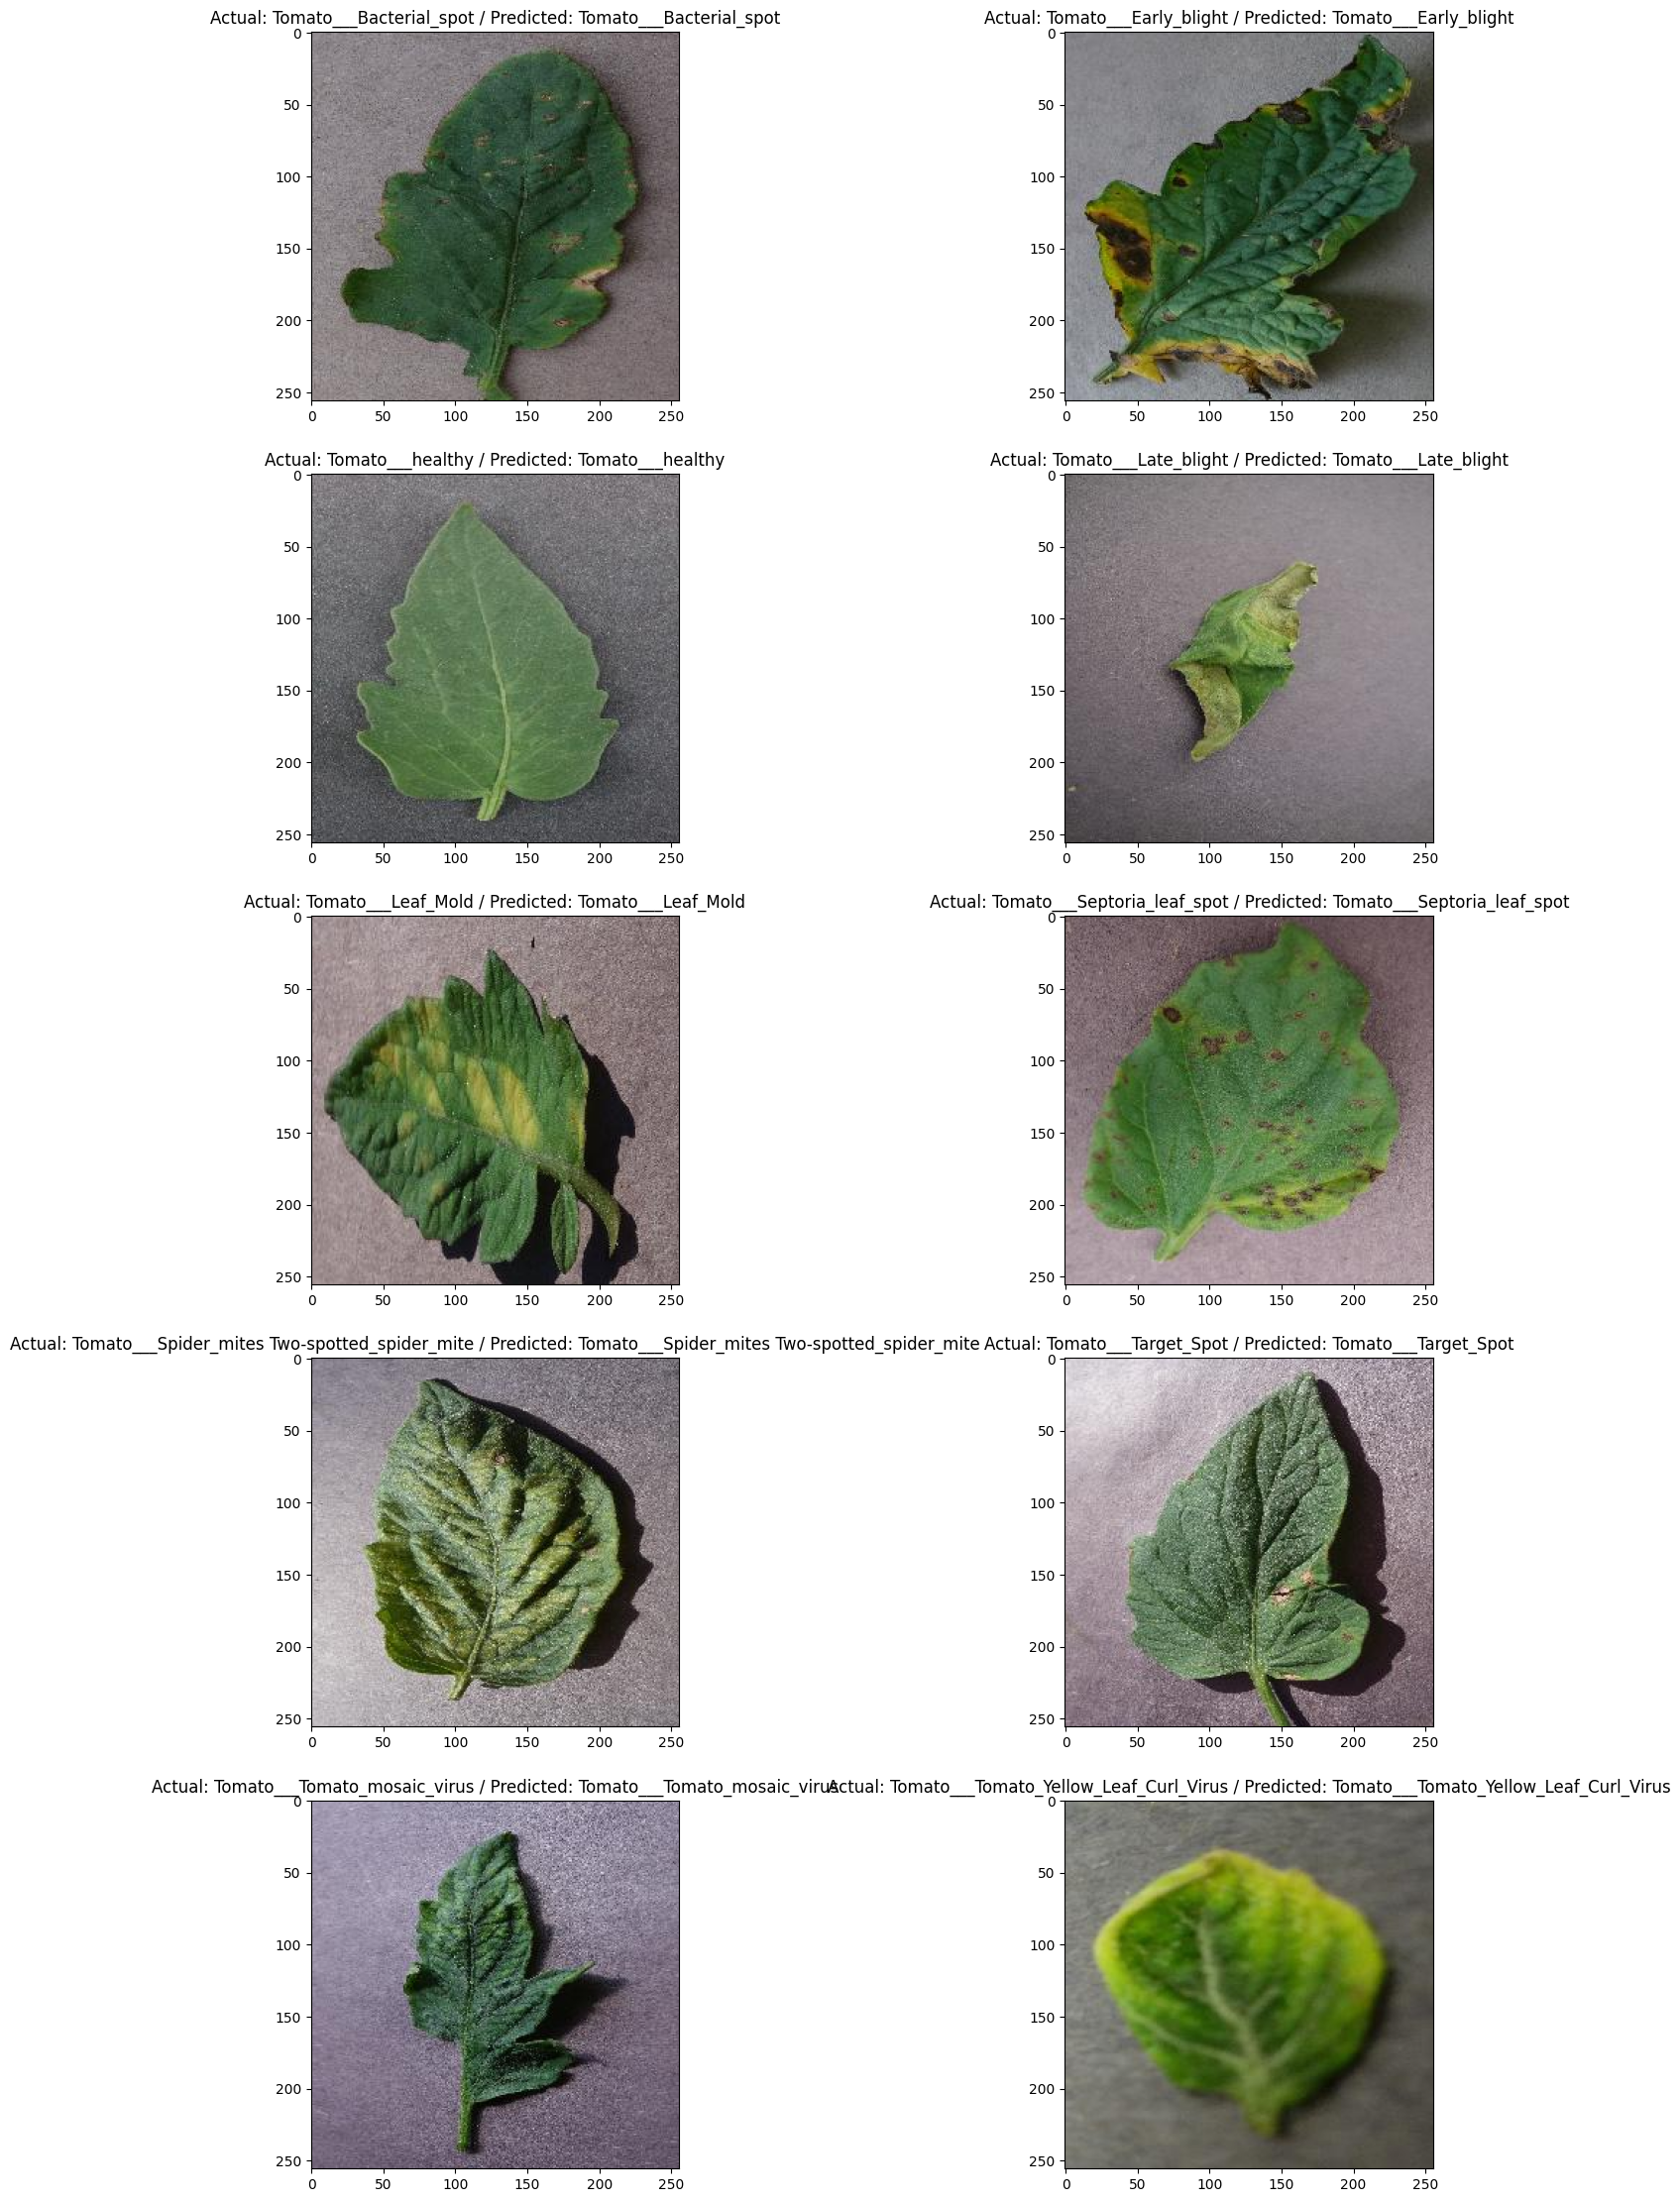

In [21]:
# Prediction and visualizations

classes = os.listdir('./val')

plt.figure(figsize=(18,28))

for i in enumerate(classes):
    pic = os.listdir('./val/'+i[1])
    pic = pic[np.random.randint(len(pic)-1)]
    image = Image.open('./val/'+i[1]+'/'+pic)
    image = np.asarray(image)
    
    pred = np.argmax(VGG16_model.predict(image.reshape(-1,256,256,3)/255))
    print(pred)
    for j in list(enumerate(list(test.class_indices.keys()))):
        if pred == j[0]:
            prediction =  j[1]
    
    plt.subplot(5,2,i[0]+1)
    plt.title('Actual: {0} / Predicted: {1}'.format(i[1], prediction))
    plt.imshow(image)
plt.show()

##### 2. Evaluating VGG16_model 

In [16]:
# Load the best model if necessary
# Initialize the model
ResNet152V2_Model.load_weights('best_resnet152v2_model.h5')

# Evaluate on validation data
val_loss, val_accuracy = ResNet152V2_Model.evaluate(val)

94/94 [==============================] - 23s 243ms/step - loss: 0.0654 - accuracy: 0.9787


In [22]:
# Print evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Loss: 0.1208934634923935
Validation Accuracy: 0.9646666646003723


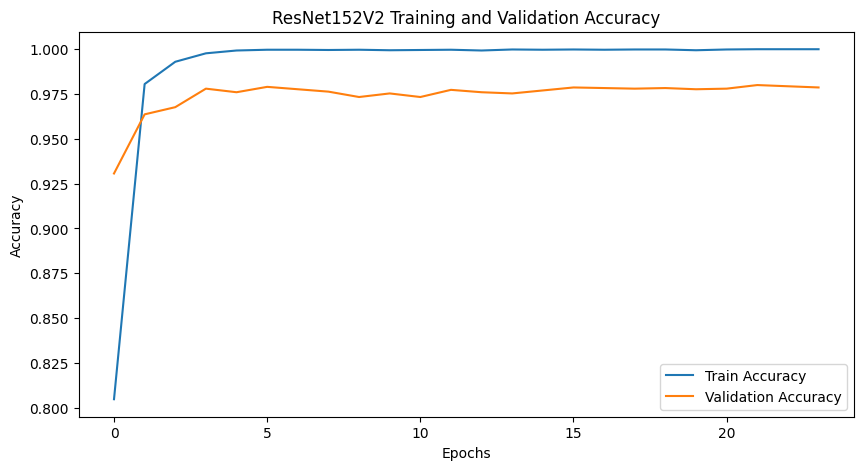

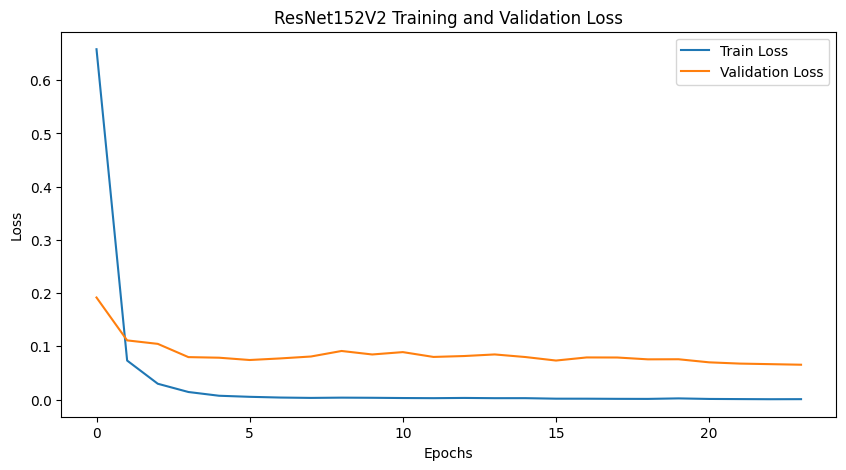

In [23]:

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(ResNet152V2History.history['accuracy'], label='Train Accuracy')
plt.plot(ResNet152V2History.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet152V2 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(ResNet152V2History.history['loss'], label='Train Loss')
plt.plot(ResNet152V2History.history['val_loss'], label='Validation Loss')
plt.title('ResNet152V2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 45ms/step


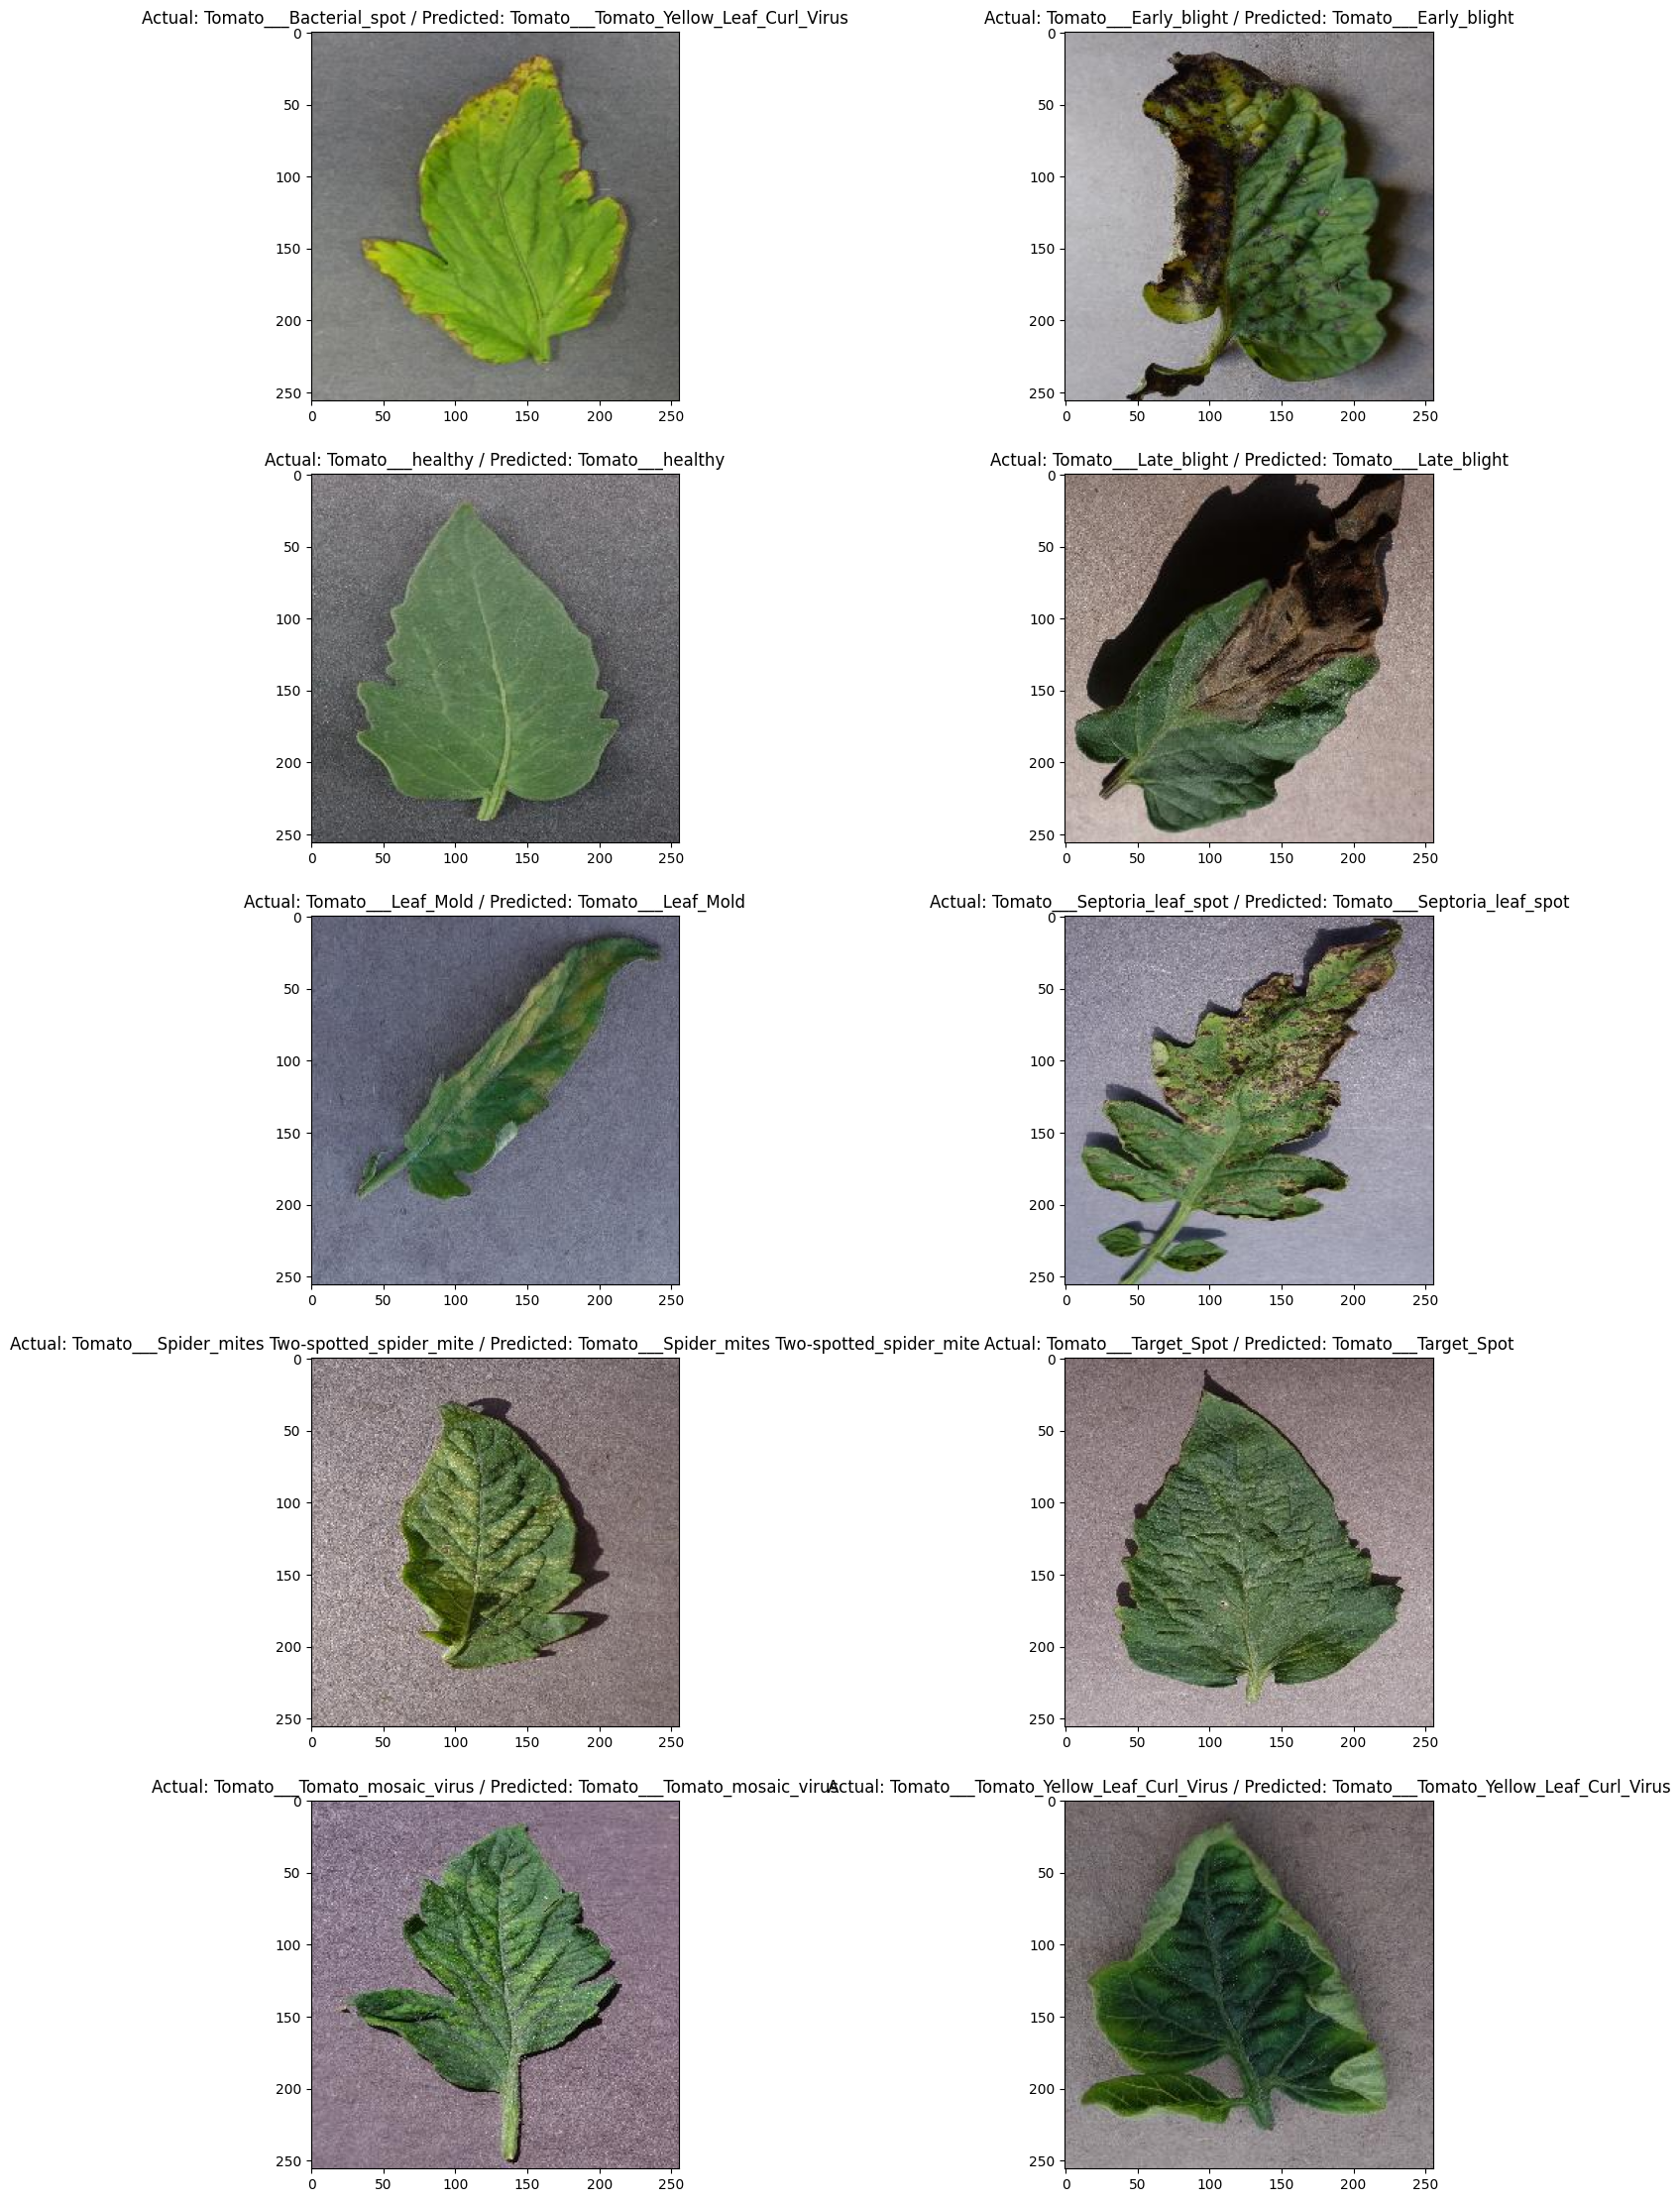

In [24]:
# Prediction and visualizations

classes = os.listdir('./val')

plt.figure(figsize=(18,28))

for i in enumerate(classes):
    pic = os.listdir('./val/'+i[1])
    pic = pic[np.random.randint(len(pic)-1)]
    image = Image.open('./val/'+i[1]+'/'+pic)
    image = np.asarray(image)
    
    pred = np.argmax(ResNet152V2_Model.predict(image.reshape(-1,256,256,3)/255))
    for j in list(enumerate(list(test.class_indices.keys()))):
        if pred == j[0]:
            prediction =  j[1]
    
    plt.subplot(5,2,i[0]+1)
    plt.title('Actual: {0} / Predicted: {1}'.format(i[1], prediction))
    
    plt.imshow(image)
plt.show()